# Tutorial 8: Monte-Carlo EM
Lecturer: Harold Soh

TA: Eugene Lim (AY23/24)

This code accompanies Tutorial 8 on the Monte-Carlo Expectation Maximization (MCEM) method. In this tutorial, we will apply Monte-Carlo methods to models where the posterior $p(z|x, \theta^{old})$ is intractable. At a high-level, we will apply Monte-Carlo methods to estimate the expectation of the log joint under the posterior, $\mathbb{E}_{p(z|x, \theta^{old})}[\log p(x,z)]$. 

This code was written by the teaching team with assistance from ChatGPT. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

from tqdm.notebook import tqdm


## The Model 

Our model will be similar to the PPCA model covered in a previous tutorial, except that now, we will have a *nonlinear* relationship between $z_n$ and $x_n$. Consider that we have a dataset $\mathcal{D} = \{ x_1, \dots, x_N \}$. Our assumed model is: 
$$z_n \sim N(\mu, s^2)$$ 
$$x_n | z_n \sim N( f(z_n), \sigma^2)$$ 
$$f(z_n) = \alpha \sin(z_n) + \beta$$

To keep things simple, $x_n$ and $z_n$ are one-dimensional and assume that $s^2$ and $\sigma^2$ are known. The unknown parameters of our model are $\theta = \{\mu, \alpha, \beta\}$. We want to learn $\theta$. 

Let's start by creating our dataset. The "true" parameters (except for $s^2$ and $\sigma^2$) are unknown to us and later, we will compare what we learn to these parameters.

In [2]:
# Parameters (these are the true parameters (unknown); you can change them)
mu_true = 0.0
alpha_true = 3
beta_true = 1
s2_true = 2
sigma2_true = 0.1
N = 100

true_params = {'mu': mu_true, 'alpha': alpha_true, 'beta':beta_true}


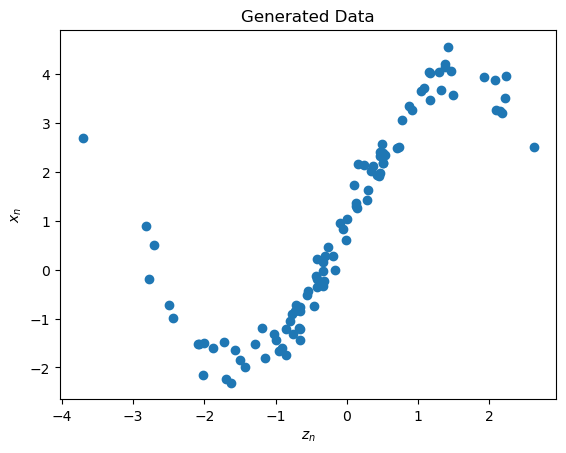

In [3]:
np.random.seed(42)  # For reproducibility

# Generate latent variables z_n
z_n = np.random.normal(mu_true, np.sqrt(s2_true), N)

# Generate observed variables x_n
x_n = np.random.normal(alpha_true * np.sin(z_n) + beta_true, np.sqrt(sigma2_true), N)

plt.scatter(z_n, x_n)
plt.xlabel('$z_n$')
plt.ylabel('$x_n$')
plt.title('Generated Data')

plt.savefig("mcem_data.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [4]:
def compute_log_likelihood(z, x, params, s2, sigma2):
    """
    Compute the average log likelihood of generated data under the model with given parameters.
    
    Args:
    - z: Array of latent variables z_n.
    - x: Array of observed data points x_n corresponding to z_n.
    - params: Dictionary containing the model parameters {'mu': mu, 'alpha': alpha, 'beta': beta}.
    - s2: Known variance of z_n.
    - sigma2: Known variance of x_n given z_n.
    
    Returns:
    - The total log likelihood of the data under the model.
    """
    mu, alpha, beta = params['mu'], params['alpha'], params['beta']
    
    # Log likelihood contribution from the prior on z
    log_likelihood_z = -0.5 * np.sum(((z - mu)**2) / s2)
    
    # Log likelihood contribution from the likelihood of x given z
    log_likelihood_x_given_z = -0.5 * np.sum(((x - (alpha * np.sin(z) + beta))**2) / sigma2)
    
    # Normalize by the constants for the Gaussian distributions
    normalization_z = -0.5 * len(z) * np.log(2 * np.pi * s2)
    normalization_x_given_z = -0.5 * len(x) * np.log(2 * np.pi * sigma2)
    
    # Total log likelihood is the sum of the contributions
    total_log_likelihood = log_likelihood_z + log_likelihood_x_given_z + normalization_z + normalization_x_given_z
    
    return total_log_likelihood


Notice that the relationship between $x_n$ and $z_n$ is nonlinear (unlike in the PPCA case). This makes it difficult to learn.

## Monte-Carlo E-M algorithm 

Recall that the E-M algorithm comprises two steps: the E-step and the M-step. In the E-step, we seek to compute the posterior over the latent variables given the old parameters $p(z|x, \theta^{old})$. We then form the $Q(\theta;  \theta^{old})$ function that we will try to maximize:
$$\theta^{new} = \arg\max_{\theta} Q(\theta;  \theta^{old})$$
where
$$Q(\theta;  \theta^{old}) =  \mathbb{E}_{p(z|x, \theta^{old})}[\log p(x,z)]$$

Here, the posterior is no longer a simple Gaussian sincce $f$ is nonlinear. This posterior is difficult for us to figure out, so we will approximate the $Q$ function using samples. 

In the tutorial, we showed that we only need to compute the following expectations:
- **(A)**  $\mathbb{E}_{p(z|x, \theta^{old})}[ (x_n - f(z_n))^2 ]$
- **(B)**  $\mathbb{E}_{p(z|x, \theta^{old})}[ (z_n - \mu)^2 ]$

We will estimate these expectations using:
1. Importance Sampling
2. Metropolis-Hastings
3. [Metropolis-Adjusted Lanngevin Algorithm (MALA)](https://en.wikipedia.org/wiki/Metropolis-adjusted_Langevin_algorithm): This is an *optional* extra for students interested in more advanced methods. 


### Importance Sampling

Let's start off using importance sampling. We will be using the self-normalized importance sampling (SNIS) which we have covered in lecture. For example, we will approximate (A) above via:
$$\mathbb{E}_{p(z|x, \theta^{old})}[ (x_n - f(z_n))^2 ] \approx \sum_{i=1}^M \tilde{w}_i (x_n - f(z_n^{(i)}))^2 $$
where $$\tilde{w}_i = \dfrac{\tilde{p}(z_n^{(i)}) / \tilde{q}(z_n^{(i)})}{ \sum_{j=1}^M \tilde{p}(z_n^{(j)}) / \tilde{q}(z_n^{(j)}) }$$

We will define a simple normal distributions with mean $m$ and variance $v^2$ as the proposal distribution.

In [5]:
def proposal_distribution(m, v2, size):
    """Generate samples from a Normal distribution with mean mu_old and variance v2."""
    return np.random.normal(m, np.sqrt(v2), size)


In [6]:
def importance_sampling(x_n, mu_old, alpha, beta, sigma2, s2, v2, proposal_dist, N_samples=1000):
    """
    Perform importance sampling with a given proposal distribution.
    
    Args:
    - x_n: A 1D array of observed data.
    - mu_old: The current estimate of the mu parameter.
    - alpha: Current estimate of the alpha parameter.
    - beta: Current estimate of the beta parameter.
    - sigma2: Known variance of x_n given z_n.
    - s2: Known variance of z_n.
    - v2: Variance parameter for the proposal distribution.
    - proposal_dist: A function to generate samples from the proposal distribution.
    - N_samples: Number of samples to draw from the proposal distribution.
    
    Returns:
    - z_samples: A 2D array of sampled latent variables (shape: (N, N_samples)).
    - weights: A 2D array of weights for each sampled latent variable (shape: (N, N_samples)).
    """
    N = len(x_n)
    z_samples = proposal_dist(mu_old, v2, (N, N_samples))
    
    # Compute unnormalized weights
    log_weights = (-0.5 / sigma2 * (x_n[:, None] - (alpha * np.sin(z_samples) + beta))**2 -
                   0.5 / s2 * (z_samples - mu_old)**2 + 
                   0.5 / v2 * (z_samples - mu_old)**2)
    # Normalize the log weights to prevent underflow/overflow
    log_weights -= np.max(log_weights, axis=1, keepdims=True)
    weights = np.exp(log_weights)
    weights /= np.sum(weights, axis=1, keepdims=True)
    
    return z_samples, weights


Once we obtain samples and weights using the importance sampling scheme, we can update the parameters. Here, we show two different ways. First, we can update the weights analytically. For A:
$$\max_\theta \sum_{i=1}^M \tilde{w}_i (x_n - \alpha \sin(z_n^{(i)}) + \beta)^2$$
which is a simple linear function in the parameters $\alpha$ and $\beta$ and we can solve using the methods we already derived in the last 1/2 semester. 

Likewise, B is also quite simple:
$$\max_\theta \sum_{i=1}^M \tilde{w}_i (z_n^{(i)} - \mu)^2$$


In [7]:
def update_theta_analytical(z_samples, weights, x_n):
    """
    Update parameters mu, alpha, and beta analytically.
    
    Args:
    - z_samples: A 2D array of shape (N, N_samples) with sampled latent variables.
    - weights: A 2D array of shape (N, N_samples) with weights for each sample.
    - x_n: A 1D array of shape (N,) with observed data.
    
    Returns:
    - A tuple (mu_new, alpha_new, beta_new) with updated parameter values.
    """
    # Update mu as the weighted mean of z_samples
    mu_new = np.sum(weights * z_samples) / np.sum(weights)
    
    # Preparing the design matrix for weighted linear regression
    N, N_samples = z_samples.shape
    sin_z = np.sin(z_samples)  # Transform z_samples with sin for the alpha term
    ones = np.ones((N, N_samples))  # Intercept term for beta
    X = np.stack([sin_z, ones], axis=-1)  # Shape (N, N_samples, 2)
    
    # Weighted linear regression to update alpha and beta
    # Flatten X and x_n for dot product, weights remain the same shape
    X_flat = X.reshape(-1, 2)  # Shape (N*N_samples, 2)
    x_n_repeated = np.repeat(x_n, N_samples)  # Repeat x_n to match the shape of X_flat
    W_flat = weights.flatten()
    
    # Compute (X^T W X)^(-1) X^T W y
    W_diag = np.diag(W_flat)  # Convert weights to a diagonal matrix
    XTWX = X_flat.T @ W_diag @ X_flat
    XTWy = X_flat.T @ W_diag @ x_n_repeated
    
    theta_new = np.linalg.inv(XTWX) @ XTWy
    alpha_new, beta_new = theta_new
    
    return mu_new, alpha_new, beta_new


It turned out above that for this model, updating the parameters was quite simple. But you should think to yourself whether optimizing it in this manner is a good idea (is the Q function after approximation still a lower bound? what is the approximation error involved?) In practice for more complex models, it is sometimes worth using a gradient ascent method which we show below. 

In [8]:
def update_theta_gradient_ascent(z_samples, weights, x_n, initial_params, learning_rate=0.01, n_iter=100):
    mu, alpha, beta = initial_params['mu'], initial_params['alpha'], initial_params['beta']
    
    N, N_samples = z_samples.shape

    x_n_repeated = np.repeat(x_n[:, None], N_samples, axis=1).flatten()
    
    for _ in range(n_iter):
        # Flatten z_samples and weights for gradient computation
        z_flat = z_samples.flatten()
        weights_flat = weights.flatten()
        
        # Gradient Computation
        grad_mu = np.sum(weights_flat * (z_flat - mu)) / np.sum(weights_flat)
        grad_alpha = np.sum(weights_flat * (x_n_repeated - (alpha * np.sin(z_flat) + beta)) * np.sin(z_flat)) / np.sum(weights_flat)
        grad_beta = np.sum(weights_flat * (x_n_repeated - (alpha * np.sin(z_flat) + beta))) / np.sum(weights_flat)
        
        # Update parameters using gradient ascent
        mu += learning_rate * grad_mu
        alpha += learning_rate * grad_alpha
        beta += learning_rate * grad_beta
    
    return mu, alpha, beta
     


#### Importance Sampling EM

The following code implements the MCEM algorithm with importance sampling. The setup is quite simple: we are still performing the E and M steps, except that we will work with samples to compute the expectation (instead of an analytical posterior). 


In [9]:
def mcem_snis(x_n, initial_params, sigma2, s2, v2, proposal, max_iter=100, 
              N_samples=100, tol=1e-6, learning_rate=0.01, n_gd_steps=10):
    """
    Monte Carlo EM algorithm to estimate parameters of the model.
    
    Args:
    - x_n: A 1D array of observed data.
    - initial_params: Dictionary with initial estimates for parameters mu, alpha, and beta.
    - sigma2: Known variance of x_n given z_n.
    - s2: Known variance of z_n.
    - v2: Variance of the proposal distribution for importance sampling.
    - max_iter: Maximum number of iterations to run the MCEM algorithm.
    - tol: Tolerance for the convergence criterion.
    
    Returns:
    - A dictionary with the estimated parameters mu, alpha, and beta.
    """
    mu, alpha, beta = initial_params['mu'], initial_params['alpha'], initial_params['beta']
    params_history = [(mu, alpha, beta)]  # Keep track of parameter updates
    

    current_params = {
        "mu": initial_params['mu'],
        "alpha": initial_params['alpha'], 
        "beta": initial_params['beta']
    }
    
    for iteration in tqdm(range(max_iter), desc='MCEM Progress'):
        # E-Step: Perform importance sampling to approximate the expectations
        z_samples, weights = importance_sampling(x_n, mu, alpha, beta, sigma2, s2, v2,
                                         proposal_dist=proposal, N_samples=N_samples)


        # M-Step: Update parameters analytically based on sampled latent variables and weights
        # mu, alpha, beta = update_theta_analytical(z_samples, weights, x_n)
        mu, alpha, beta = update_theta_gradient_ascent(z_samples, weights, x_n, 
                                                       current_params, 
                                                       learning_rate=learning_rate, n_iter=n_gd_steps)
        current_params["mu"] = mu
        current_params["alpha"] = alpha
        current_params["beta"] = beta
        
        params_history.append((mu, alpha, beta))

        # Check for convergence
        delta = np.sqrt((params_history[-1][0] - params_history[-2][0])**2 +
                        (params_history[-1][1] - params_history[-2][1])**2 +
                        (params_history[-1][2] - params_history[-2][2])**2)

        if delta < tol:
            print(f"Convergence reached after {iteration + 1} iterations.")
            break

    
    return {'mu': mu, 'alpha': alpha, 'beta': beta}


With all that, let's now run the MCEM algorithm with importance sampling. 

In [10]:
# Let's start the initial parameters and then learn the parameters \theta 

initial_params = {'mu': 0.1, 'alpha': 0.1, 'beta': 0.1}

# you can change the following parameters to see their effects
v2 = 1
max_iter = 200  # iterations of EM
N_samples = 100 # number of samples for each x_n

learning_rate=0.01
n_gd_steps=10

# run the MCEM algorithm
estimated_params = mcem_snis(x_n, initial_params, sigma2_true, s2_true, v2,
                             proposal=proposal_distribution,
                             max_iter=max_iter, N_samples=N_samples,
                             learning_rate=learning_rate, n_gd_steps=n_gd_steps
                            )
print(estimated_params)

MCEM Progress:   0%|          | 0/200 [00:00<?, ?it/s]

{'mu': -0.18214357169787307, 'alpha': 2.875015832195142, 'beta': 1.1138072419794602}


Now, let's compare the true and estimated parameters in terms of their values, and also by plotting data generated. 

In [11]:

print("True params: ", true_params)
print("Learned params: ", estimated_params)

True params:  {'mu': 0.0, 'alpha': 3, 'beta': 1}
Learned params:  {'mu': -0.18214357169787307, 'alpha': 2.875015832195142, 'beta': 1.1138072419794602}


In [12]:
def plot_result(true_params, estimated_params, N=50, seed=42):
    # Generate data with true parameters
    np.random.seed(seed)
    mu_true = true_params['mu']
    alpha_true = true_params['alpha']
    beta_true = true_params['beta']
    z_n_true = np.random.normal(mu_true, np.sqrt(s2_true), N)
    x_n_true = np.random.normal(alpha_true * np.sin(z_n_true) + beta_true, np.sqrt(sigma2_true), N)

    # Simulated data using estimated parameters
    mu_est = estimated_params['mu']
    alpha_est = estimated_params['alpha']
    beta_est = estimated_params['beta']

    z_n_est = np.random.normal(mu_est, np.sqrt(s2_true), N)
    x_n_est = np.random.normal(alpha_est * np.sin(z_n_est) + beta_est, np.sqrt(sigma2_true), N)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(z_n_true, x_n_true, color='blue', alpha=0.5, label='True Parameters')
    plt.scatter(z_n_est, x_n_est, color='green', alpha=0.5, label='Learned Parameters')
    plt.title('Data Generated with True vs. Learned Parameters')
    plt.xlabel('$z_n$')
    plt.ylabel('$x_n$')
    plt.legend()
    plt.show()
    
def get_score(true_aprams, estimated_params, N=10000, seed=42):
    mu_est = estimated_params['mu']
    alpha_est = estimated_params['alpha']
    beta_est = estimated_params['beta']
    z_n_est = np.random.normal(mu_est, np.sqrt(s2_true), N)
    x_n_est = np.random.normal(alpha_est * np.sin(z_n_est) + beta_est, np.sqrt(sigma2_true), N)
    score = -compute_log_likelihood(z_n_est, x_n_est, true_params, s2_true, sigma2_true)/1000
    print("Avg NLL of generated data(under true model): ", score)
    

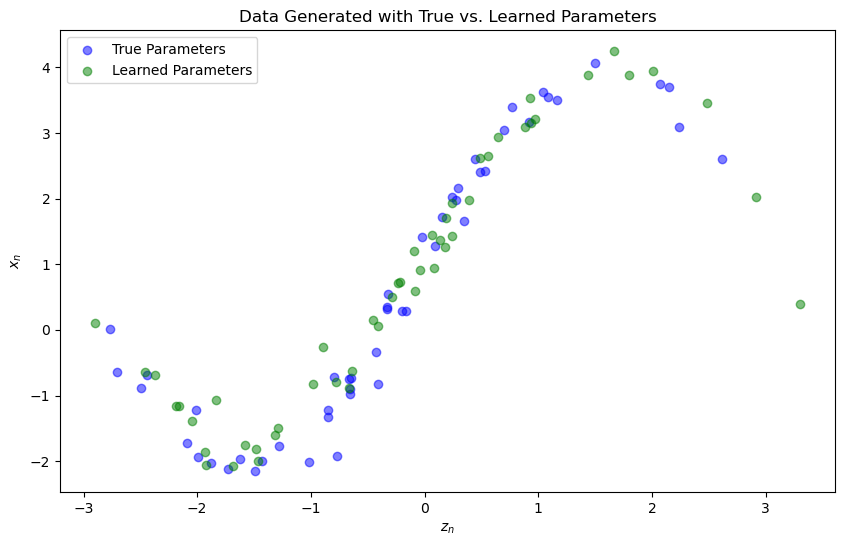

Avg NLL of generated data(under true model):  21.681823369320146


In [13]:
plot_result(true_params, estimated_params, N=50)
get_score(true_params, estimated_params)

With good algorithm parameters (sufficient samples and iterations), you should see the learned parameters to be reasonably close to the true ones (although they may not match completely. why? which parameters are more difficult to learn for this problem?). Moreover, the data generated will also look similar to the data from the true underlying model. 

Hopefully, you can see how useful sampling can be. We started off with a posterior that we didn't know how to evaluate and ended up able to learn the parameters for our model! 

### Metropolis-Hastings Monte-Carlo 

In lectures, we covered the MCMC algorithm for generating samples and here, we will make use of the Metropolis method for approximating our expectations (A) and (B). In MCMC, we will need to define a proposal distribution and we will use a normal centered aorund the current point. 


In [14]:
def target_density(z, x, mu, alpha, beta, sigma2, s2):
    """
    Compute the unnormalized posterior density p(z|x, theta).
    
    Args:
    - z: The latent variable for which to compute the density.
    - x: The observed data.
    - mu, alpha, beta: Parameters of the model.
    - sigma2: Variance of x given z.
    - s2: Variance of z.
    
    Returns:
    - The unnormalized posterior density.
    """
    prior = np.exp(-(z - mu)**2 / (2 * s2))
    likelihood = np.exp(-(x - (alpha * np.sin(z) + beta))**2 / (2 * sigma2))
    return prior * likelihood


In [15]:
def metropolis_hastings(target_density, proposal_func, proposal_pdf, initial_z, x, n_samples, burn_in):
    """
    Draw samples using the Metropolis-Hastings algorithm with a general proposal distribution.
    
    Args:
    - target_density: Function to compute the target density p(z).
    - proposal_func: Function to generate a proposal given the current state.
    - proposal_pdf: Function to compute the probability density of the proposal.
    - initial_z: Initial value of z to start the MCMC chain.
    - x: observation x
    - n_samples: Total number of samples to draw, including burn-in.
    - burn_in: Number of initial samples to discard (burn-in period).
    
    Returns:
    - samples: A 1D array of samples drawn from the target distribution after burn-in.
    """
    samples = np.zeros(n_samples)
    current_z = initial_z
    
    for i in range(n_samples):
        proposal = proposal_func(current_z, x)
        
        # Compute acceptance probability
        acceptance_ratio = (target_density(proposal, x) * proposal_pdf(current_z, proposal, x)) / \
                           (target_density(current_z, x) * proposal_pdf(proposal, current_z, x))
        acceptance_prob = min(1, acceptance_ratio)
        
        # Draw a uniform random number for acceptance test
        u = np.random.uniform(0, 1)
        
        if u < acceptance_prob:
            current_z = proposal  # Accept proposal
        
        samples[i] = current_z
    
    return samples[burn_in:]  # Discard burn-in samples


In [16]:
def normal_proposal(z, x, params):
    """
    Generate a proposal sample using a Normal distribution centered at z.
    
    Args:
    - z: Current state.
    - params: parameters
        - sigma: Standard deviation of the proposal distribution.
    
    Returns:
    - Proposal sample.
    """
    sigma = params['sigma']
    return np.random.normal(z, sigma)

def normal_proposal_pdf(z, z_prime, x, params):
    """    
    Args:
    - z: Current state (not used in calculation for symmetric proposals).
    - z_prime: Proposed state (not used in calculation for symmetric proposals).
    - params: parameters
        - sigma: Standard deviation of the proposal distribution (not used for symmetric proposals).
    
    Returns:
    - Probability density (constant for symmetric proposals).
    """
    return 1.0  # Symmetric proposal, cancels out in acceptance ratio


#### MCEM with MCMC

The following implements the MCEM algorithm using MCMC for sampling and gradient descent for the parameter updates. The setup is similar to the importance sampling variant.

In [17]:
def mcem_mcmc_gd(x_n, initial_params, sigma2, s2, v2, 
                 target_density, proposal_func, proposal_pdf, proposal_params,
                 n_samples=10000, burn_in=1000, learning_rate=0.01, 
                 n_gd_steps=10, n_iter=100):
    """
    MCEM algorithm using generalized Metropolis-Hastings for sampling and gradient descent for parameter updates.
    
    Args:
    - x_n: Observed data.
    - initial_params: Initial parameter estimates for mu, alpha, and beta.
    - sigma2, s2: Known variances.
    - v2: Variance of the proposal distribution for MCMC.
    - target_density: Target density function for MCMC.
    - proposal_func: Proposal function for MCMC.
    - proposal_pdf: Proposal PDF function for MCMC.
    - n_samples: Total number of MCMC samples to draw, including burn-in.
    - burn_in: Number of initial samples to discard (burn-in period).
    - learning_rate: Learning rate for gradient descent updates.
    - n_gd_steps: Number of gradient descent steps for parameter updates.
    - n_iter: Number of iterations for the EM algorithm.
    
    Returns:
    - Updated parameter estimates.
    """
    mu, alpha, beta = initial_params['mu'], initial_params['alpha'], initial_params['beta']
    
    for it in tqdm(range(n_iter), desc="MCEM Iterations"):

        if proposal_params["name"] == "langevin":
            proposal_params["gradient_logp"] = lambda z, x: gradient_logp(z, x, mu, alpha, beta, sigma2_true, s2_true)
        
        # E-Step: Draw samples for each observed data point using Metropolis-Hastings
        z_samples_all = []
        for x in x_n:
            samples = metropolis_hastings(lambda z, x: target_density(z, x, mu, alpha, beta, sigma2, s2),
                                          lambda z, x: proposal_func(z, x, proposal_params),
                                          lambda z, z_prime, x: proposal_pdf(z, z_prime, x, proposal_params),
                                          mu, x, n_samples, burn_in)
            z_samples_all.extend(samples)
        
        z_samples_all = np.array(z_samples_all)
        
        # M-Step: Update parameters using gradient descent
        n_post_burn_in_samples = n_samples - burn_in
        x_n_replicated = np.repeat(x_n, n_post_burn_in_samples)
        
        for gd_step in range(n_gd_steps):
            grad_mu = np.mean(z_samples_all) - mu
            grad_alpha = np.mean((x_n_replicated - (alpha * np.sin(z_samples_all) + beta)) * np.sin(z_samples_all))
            grad_beta = np.mean(x_n_replicated - (alpha * np.sin(z_samples_all) + beta))
            
            # Update parameters
            mu += learning_rate * grad_mu
            alpha += learning_rate * grad_alpha
            beta += learning_rate * grad_beta
    
    return {'mu': mu, 'alpha': alpha, 'beta': beta}


In [18]:
print("True parameters: ", true_params)

# Initial parameters for estimation
initial_params = {'mu': 0.1, 'alpha': 0.1, 'beta': 0.1}

# Proposal distribution variance and MCMC setup
v2 = 0.5
max_iter = 100  # Number of iterations for the MCEM algorithm
N_samples = 100  # Number of MCMC samples to draw per observation, including burn-in
burn_in = int(0.1 * N_samples)  # Burn-in period (10% of N_samples)

learning_rate = 0.05 # learning rate for gradient descent
n_gd_steps = 10 # number of gradient descent steps

proposal_params = {
    "name": "normal",
    "sigma": np.sqrt(v2)}

# Running the MCEM algorithm with MCMC
estimated_params = mcem_mcmc_gd(x_n, initial_params, sigma2_true, s2_true, v2, 
                                target_density, normal_proposal, normal_proposal_pdf, proposal_params,
                                n_samples=N_samples, burn_in=burn_in, 
                                learning_rate=learning_rate, n_gd_steps=n_gd_steps,
                                n_iter=max_iter)

print("Estimated Parameters:", estimated_params)


True parameters:  {'mu': 0.0, 'alpha': 3, 'beta': 1}


MCEM Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Estimated Parameters: {'mu': -0.15326771101901404, 'alpha': 2.903216308272276, 'beta': 1.1250602718722433}


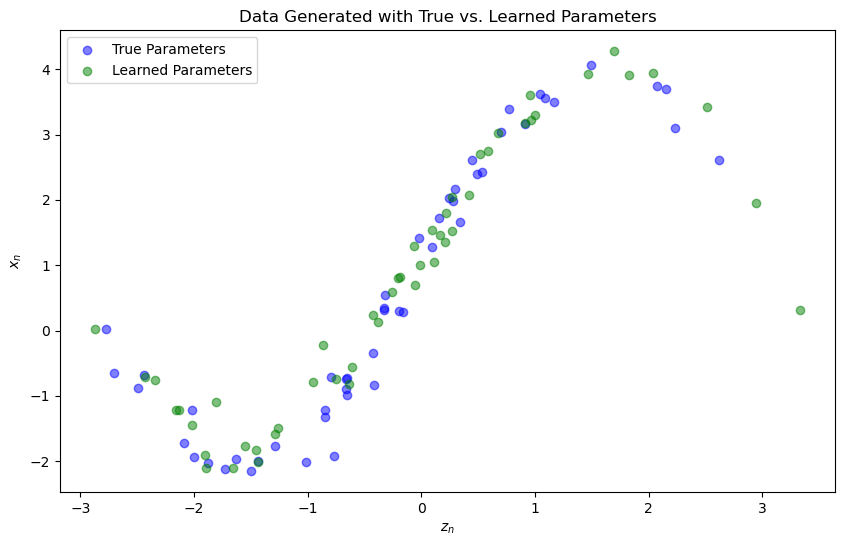

Avg NLL of generated data(under true model):  21.61140966023055


In [19]:
plot_result(true_params, estimated_params, N=50)
get_score(true_params, estimated_params)

Again, with good algorithm parameters, you should find that the learned parameters are reasonably close to the true ones. The data generated should look similar to the true model. 

Now you have a second sampling method you can apply towards solving more complex models. You can stop here if you want or if you are feeling a bit more adventuous, you can see a third sampling approach below. 


### Metropolis-Adjusted Langevin Algorithm (MALA)

The MALA algorithm uses the gradient of the target density to drive the random walk towards region of high probability. This can improve the mixing times associated with MCMC methods. The proposal for MALA is given by

$$z_{t+1} = z_t + \tau \nabla \log p(z, x) + \sqrt{2\tau}\epsilon$$ 
where $\epsilon \sim N(0,1)$. 


In [20]:
# Define gradient_logp function for your model
def gradient_logp(z, x, mu, alpha, beta, sigma2, s2):
    """
    Compute the gradient of the log posterior (target density) with respect to z.
    """
    grad = (alpha / sigma2) * (x - alpha * np.sin(z) - beta) * np.cos(z) - (1 / s2) * (z - mu)
    return grad


def langevin_proposal(current_z, x, params):
    """
    Generate a proposal using Langevin dynamics with a specified step size and gradient function.
    
    Args:
    - current_z: Current state.
    - params: parameters
        - gradient_logp: Function to compute the gradient of the log target density.
        - step_size: Step size parameter for the proposal.
    
    Returns:
    - Proposal sample.
    """
    
    gradient_logp = params["gradient_logp"] 
    step_size = params["step_size"]
    
    noise = np.random.normal(0, 1)
    proposal = current_z + step_size * gradient_logp(current_z, x) + np.sqrt(2*step_size)*noise
    return proposal

def langevin_proposal_pdf(z, z_prime, x, params):
    """
    Compute the probability density of proposing x_prime given x under Langevin dynamics.
    For this simple implementation, we can assume it to be symmetric.
    
    Args:
    - z: Current state.
    - z_prime: Proposed state.
    - params: parameters
    
    Returns:
    - Probability density.
    """
    
    gradient_logp = params["gradient_logp"] 
    step_size = params["step_size"]
    
    return np.exp(- (1/(4*step_size))*( z_prime - z - step_size*gradient_logp(z, x))**2 ) 

    

Let's run MALA by just using the langevin proposal and pdf defined above. We can reuse the MCEM_MCMC function above!

In [21]:
print("True parameters: ", true_params)

# Initial parameters for estimation
initial_params = {'mu': 0.1, 'alpha': 0.1, 'beta': 0.1}

# Proposal distribution variance and MCMC setup
v2 = 0.5
step_size = 0.01
max_iter = 200  # Number of iterations for the MCEM algorithm
N_samples = 50  # Number of samples to draw per observation, including burn-in
burn_in = int(0.1 * N_samples)  # Burn-in period (10% of N_samples)

lanvegin_params = {
    'name': 'langevin',
    "step_size": step_size,
}

# Running the MCEM algorithm with Langevin Dynamics
estimated_params = mcem_mcmc_gd(x_n, initial_params, sigma2_true, s2_true, v2, 
                                target_density, langevin_proposal, langevin_proposal_pdf, lanvegin_params,
                                n_samples=N_samples, burn_in=burn_in, 
                                learning_rate=0.01, n_gd_steps=10,
                                n_iter=max_iter)

print("Estimated Parameters:", estimated_params)


True parameters:  {'mu': 0.0, 'alpha': 3, 'beta': 1}


MCEM Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Estimated Parameters: {'mu': -0.08022519490372672, 'alpha': 2.9897554369213677, 'beta': 1.089513694530203}


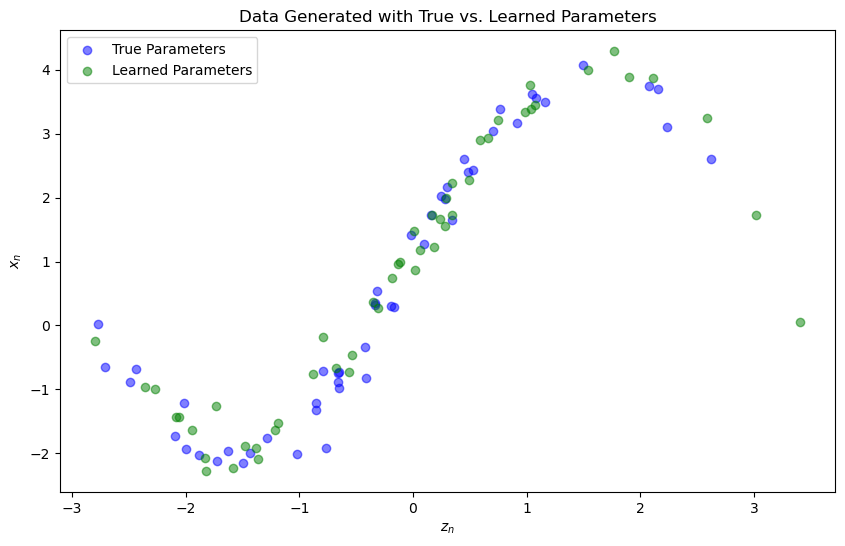

Avg NLL of generated data(under true model):  20.865390074442665


In [22]:
plot_result(true_params, estimated_params)
get_score(true_params, estimated_params)

Again, with good algorithm parameters, you should find that the learned parameters are reasonably close to the true ones (perhaps even better than the Metropolis and IS methods). 